In [86]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
import pandas as pd
from matplotlib.pyplot import figure
from itertools import cycle, islice
from power_perp import everlasting_power_perp_price, power_perp_price


In [50]:
def liteGBM(S0, mu, sigma, T, dt=1):
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt)
    S =  S0*np.exp((mu-0.5*sigma**2)*t + sigma*W)
    return np.insert(S,0,S0)

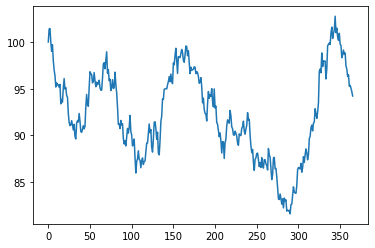

In [149]:
# One sim
S = liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)
sbn.lineplot(data=S)

In [55]:
# Set up params
spot = 100
vol = 0.8
drift = 0
funding_period = 1/365
power = 2

In [87]:
# Power perp pricing
power_perp_price(spot, funding_period, vol, drift, power)

10017.549628054265

In [56]:
# Everlasting power perp pricing
everlasting_power_perp_price(spot, funding_period, vol, drift, power)

10035.16096228955

In [166]:
# Simulator for total pnl
def simPerp(S0, mu, sigma, numPeriods, fundingPeriod, Minf): # Minf is the pricing function
    # GBM path
    S = liteGBM(S0=S0, mu = mu, sigma=sigma, T = numPeriods* fundingPeriod, dt = fundingPeriod)
    # Funding path (Mark - Index)
    d = [Minf(s)-s**2 for s in S[1:]]
    # Total cash for long power perp (cost - funding + sale) 
    return -Minf(S0) - np.sum(d) + Minf(S[-1])

In [168]:
# Use everlasting pp 
Minf = lambda spot: everlasting_power_perp_price(spot, funding_period, vol, drift, power)
tmp =[simPerp(100, 0, 0.8, 365, 1/365, Minf) for _ in range(10000)]
np.mean(tmp)

-9701.953040158382

In [169]:
# Use expiring pp 
Minf = lambda spot: power_perp_price(spot, funding_period, vol, drift, power)
tmp =[simPerp(100, 0, 0.8, 365, 1/365, Minf) for _ in range(10000)]
np.mean(tmp)

234.22773064035405

So this means that if we use `everlasting_power_perp_price` in the sims we get a persistent return (~-10k over the year) when we simulate the pnl from holding a position and paying `Mark - Index` on gbm paths. If we use `power_perp_price` the expected return is zero as we would expect. 